In [14]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import patches
from scipy.stats import chi2, norm
from scipy.optimize import minimize
from tqdm.notebook import tqdm
from statsmodels.distributions.empirical_distribution import ECDF

In [15]:
print(f'P(delta > {np.round(131.2, 3)}|H0) = {np.round(chi2(1).sf(131.2), 3)}') # 6 задача
print(f'P(delta > {np.round(20.479, 3)}|H0) = {np.round(chi2(2).sf(20.479), 3)}') # 7задача
print(f'P(delta > {np.round(2.08, 3)}|H0) = {np.round(chi2(3).sf(2.08), 3)}') # 8 задача

P(delta > 131.2|H0) = 0.0
P(delta > 20.479|H0) = 0.0
P(delta > 2.08|H0) = 0.556


In [16]:
data = np.arange(10)
data = np.vstack((data, [1/(np.max(data)-np.min(data))] * 10))
data = np.vstack((data, np.array([5, 8, 6, 12, 14, 18, 11, 6, 13, 7])))
N = int(np.sum(data[2]))
data = np.vstack((data, np.array([5, 8, 6, 12, 14, 18, 11, 6, 13, 7])/N))
delta_est = np.sum((data[2]-N*data[1])**2 / (N*data[1]))
print(f'delta_est = {np.round(delta_est, 3)}, p-value = {np.round(chi2(9).sf(delta_est), 3)}') 

delta_est = 15.871, p-value = 0.07


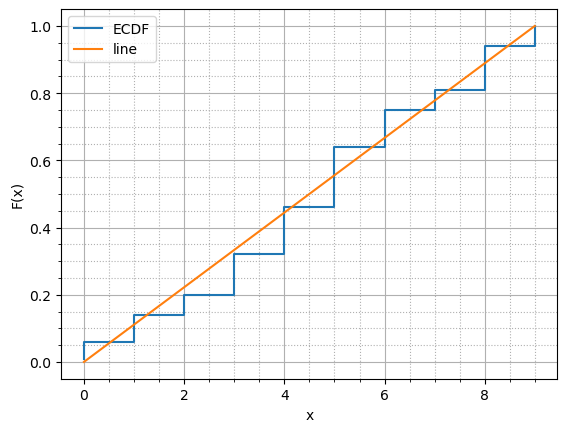

In [17]:
sample = np.concatenate(np.array([[v] * int(data[2][i]) for i, v in enumerate(data[0])], dtype=object)).astype(int)
empirical = ECDF(sample)
plt.step(empirical.x, empirical.y, label='ECDF')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.plot((empirical.x[1], empirical.x[-1]), (0, 1), label='line')
plt.legend()
plt.savefig('empirical')

In [18]:
def kolmagorov_delta_est(sample):
    x, y = np.unique(sample, return_counts=True)
    y = (y/np.sum(y)).cumsum()
    y = np.hstack((np.array([0.]), y))
    a = 1/(np.max(x)-np.min(x))
    b = -a * np.min(x)
    deltas = []
    yi = a * x
    for i in range(len(x)):
        deltas.append(max(abs(y[i+1] - yi[i]), abs(y[i] - yi[i])))
    return max(deltas) * (np.size(sample)**0.5)

def Kolmagorov_sf(x):
    a = 0
    for i in range(3):
        a += (-1)**(i+1) * np.exp(-2 * (i+1)**2 * x**2)
    return 1 - (1 + 2*a)

delta_est = kolmagorov_delta_est(sample)
print(f'delta_est = {np.round(delta_est, 3)}, p-value = {np.round(Kolmagorov_sf(delta_est), 3)}')

delta_est = 1.433, p-value = 0.033


In [19]:
intervals = np.hstack((np.array(-np.inf), data[0][1:], np.array(np.inf))) - 0.5
def maxes_probability_function(sample):
    def probability_function(variables):
        mean, sigma = variables 
        counts = []
        for i in range(len(intervals) - 1):
            a, b = intervals[i], intervals[i+1]
            counts = np.append(counts, np.count_nonzero((sample < b) & (sample >= a)))
        return -np.prod((norm(mean, sigma).cdf(intervals[1:]) - norm(mean, sigma).cdf(intervals[:-1])) ** counts) 
    initial_guess = [5.0, 3.0]
    result = minimize(probability_function, initial_guess, method = 'Nelder-Mead')
    return np.round(result.x, 3)

max_mean, max_sigma = maxes_probability_function(sample)
print(f'a = {max_mean}, sigma = {max_sigma}')

probs = (norm(max_mean, max_sigma).cdf(intervals[1:]) - norm(max_mean, max_sigma).cdf(intervals[:-1]))
print(np.round(probs, 3))

delta_est = np.sum((data[2] - N*probs)**2 / (N*probs))
print(f'delta_est = {np.round(delta_est, 3)}, p-value = {np.round(chi2(7).sf(delta_est), 3)}')

a = 4.79, sigma = 2.679
[0.055 0.055 0.087 0.119 0.142 0.148 0.134 0.106 0.073 0.083]
delta_est = 9.802, p-value = 0.2


In [26]:
class Fempirical:
    def __init__(self, sample):
        n = np.size(sample)
        x, y = np.unique(sample, return_counts=True)
        y = (y/np.sum(y)).cumsum()
        y = np.hstack((np.array([0.]), y))
        assert len(x) == len(y) - 1
        self.x = np.array(x).astype(float)
        self.y = np.array(y).astype(float)
    
    def cdf(self, x):
        if x <= np.min(self.x):
            return 0.
        elif x > np.max(self.x):
            return 1.
        return self.y[np.where((self.x >= x) == True)[0][0]]
    
class OMPG:
    def __init__(self, sample):
        self.mean, self.sigma = maxes_probability_function(sample)
        self.params = (self.mean, self.sigma)
        self.norm = norm(*self.params)
        
    def cdf(self, x):
        return self.norm.cdf(x)
    
def delta_est_Kolmagorov(F_est, F_emp):
    def delta(x):
        return -abs(F_est.cdf(x) - F_emp.cdf(x))
    result = minimize(delta, [0], method = 'Nelder-Mead')
    return N**0.5 * -delta(result.x)[0]

def delta_est_Pirson(sample, accuracy=int(1e2)):
    mean, sigma = maxes_probability_function(sample)
    normal = norm(mean, sigma)
    counts, probs = [], [] 
    for i in range(len(intervals) - 1):
        a, b = intervals[i], intervals[i+1]
        counts = np.append(counts, np.count_nonzero((np.array(sample) < b) & (np.array(sample) >= a)))
        probs = np.append(probs, normal.cdf(b) - normal.cdf(a))  
    return np.sum((counts - np.size(sample)*probs)**2 / (np.size(sample)*probs))

In [27]:
def bootstrap(sample, criterion):
    if criterion == 'Kolmagorov':
        delta_est = delta_est_Kolmagorov(OMPG(sample), Fempirical(sample))
    if criterion == 'Pirson':    
        delta_est = delta_est_Pirson(sample)
    k = 0
    for i in tqdm(range(50000)):     
        sample_cur = np.random.normal(*params, np.size(sample))
        if criterion == 'Kolmagorov':
            delta_est_cur = delta_est_Kolmagorov(OMPG(sample_cur), Fempirical(sample_cur))
        if criterion == 'Pirson':    
            delta_est_cur = delta_est_Pirson(sample_cur)
        k += delta_est_cur > delta_est
    return delta_est, k/50000

def calc_bootstrap(criterion):
    delta_est, p_value = bootstrap(sample, criterion)
    print(f'delta_est = {np.round(delta_est, 3)}, p-value = {np.round(p_value, 3)}')

In [28]:
calc_bootstrap('Pirson')

  0%|          | 0/50000 [00:00<?, ?it/s]

delta_est = 9.802, p-value = 0.202


In [29]:
calc_bootstrap('Kolmagorov')

  0%|          | 0/50000 [00:00<?, ?it/s]

delta_est = 0.369, p-value = 0.047
